In [232]:
import os, glob, time, re, json, random
import cv2
import matplotlib.pyplot as plt

class UnlabeledCsv: # pretext or unlableled inference # real data number = frames/16*1
    """
    obj = UnlabeledCsv("../_data/20220810/imgs/", "../_data/20220810/pretext_20220810_20.csv", timePath="../_data/_labels/20220810_20.txt")
    """
    def __init__(self, imgFolder, outputFolder, txtPath=None, csvPathL=[]):
        framesN = 0
        os.makedirs(outputFolder, exist_ok=True)
        with open(f"{outputFolder}/train.csv", "w") as f:
            for csvPath in csvPathL:
                for line in open(csvPath,"r").readlines():
                    f.write(line)
                    framesN+=1
            print(f"copy framesN = {framesN}")
            #
            prefixS = set( re.findall("\[(.*).mp4\]",line)[0] for line in open(txtPath,"r").readlines() if re.findall("\[.*\]",line) ) if txtPath else set()
            for imgPath in filter(lambda imgPath:re.findall('(video_[0-9]*)_',imgPath)[0] in prefixS, sorted(glob.glob(f"{imgFolder}/*.jpg"))):
                f.write( os.path.abspath(imgPath)+" 0\n" )
                framesN+=1
            print(f"overall framesN = {framesN}")
        os.system(f"cp {outputFolder}/train.csv {outputFolder}/val.csv")
        os.system(f"cp {outputFolder}/train.csv {outputFolder}/test.csv")

class LabeledCsv: # downstream # real data number = frames # active cycle must have trainCsvPathL and valCsvPath !!!
    """
    # A stack: 16 frames # posThreshold=0.75, so 16*0.25=4 # i.e. +-4 are positive
    # negThreshold=0.0 # i.e. no overlapped
    """
    def __init__(self, imgFolder, outputFolder, txtPath=None, trainCsvPathL=[], valCsvPath=None, classL=None, divide=5):
        self.fps, self.frameFreq, self.framesPerStack, posThreshold, negThreshold = 30, 4, 16, 0.75, 0.0
        self.posOverlap, self.negOverlap = round(self.framesPerStack*(1-posThreshold)), round(self.framesPerStack*negThreshold) # 4,0
        self.imgFolder  = os.path.abspath(imgFolder)
        self.imgPathL   = sorted(glob.glob(f"{self.imgFolder}/*.jpg"))           # idx2path
        self.imgPathD   = dict( zip( self.imgPathL,range(len(self.imgPathL)) ) ) # path2idx
        os.makedirs(outputFolder, exist_ok=True)
        self.outputFolder = outputFolder
        self.txtPath    = txtPath
        self.trainCsvPathL = trainCsvPathL
        self.valCsvPath = valCsvPath
        self.classL     = classL
        self.divide     = divide
    
    def cut(self):
        framesN = 0
        with open(f"{self.outputFolder}/train.csv", "w") as f:
            for csvPath in self.trainCsvPathL:
                for line in open(csvPath,"r").readlines():
                    f.write(line)
                    framesN+=1
            print(f"copy framesN = {framesN}")
            #
            for line in open(self.txtPath,"r").readlines():
                line = line.replace("\n","").replace(" ","")
                if "[" in line:
                    videoName = line[1:-1]
                    prevEnd = ""
                else:
                    for cid,timeSlot in enumerate( line.split(",") ):
                        if timeSlot in ['','-'*23]:
                            continue
                        start, end = timeSlot.split("-")
                        start, end = timeSlot.split("-")
                        (sh,sm,ss), (eh,em,es) = start.split(":"), end.split(":")
                        start, end = (int(sh)*3600+int(sm)*60+float(ss))*self.fps, (int(eh)*3600+int(em)*60+float(es))*self.fps
                        start = start//self.frameFreq*self.frameFreq + (start%self.frameFreq>=self.frameFreq/2)*self.frameFreq
                        end   =   end//self.frameFreq*self.frameFreq + (  end%self.frameFreq>=self.frameFreq/2)*self.frameFreq
                        start = '0'*(5-len(str(int(start)))) + str(int(start))
                        end   = '0'*(5-len(str(int(end  )))) + str(int(end  ))
                        start = f"{self.imgFolder}/{videoName.replace('.mp4','_'+start+'.jpg')}"
                        end   = f"{self.imgFolder}/{videoName.replace('.mp4','_'+end  +'.jpg')}"
                        # positive
                        R = list(range(self.imgPathD[start]-self.posOverlap, self.imgPathD[end]-self.framesPerStack+self.posOverlap+1))
                        random.shuffle(R)
                        for idx in R[:self.divide]:
                            f.write(f"{self.imgPathL[idx]} {cid}\n")
                            framesN+=1
                        # negative
                        if prevEnd:
                            R = list(range(self.imgPathD[prevEnd]-self.negOverlap, self.imgPathD[start]+self.negOverlap))
                            random.shuffle(R)
                            for idx in R[:self.divide]:
                                f.write(f"{self.imgPathL[idx]} {len(self.classL)}\n")
                                framesN+=1
                        prevEnd = end
            print(f"overall framesN = {framesN}")
        #
        if self.valCsvPath:
            os.system(f"cp {self.valCsvPath} {self.outputFolder}")
        else:
            lineL = open(f"{self.outputFolder}/train.csv", "r").readlines()
            random.shuffle(lineL)
            with open(f"{self.outputFolder}/train.csv", "w") as f:
                for line in lineL[:int(len(lineL)*0.8)]:                  
                    f.write(line)
            with open(f"{self.outputFolder}/val.csv", "w") as f:
                for line in lineL[int(len(lineL)*0.8):]:                  
                    f.write(line)
        os.system(f"cp {self.outputFolder}/val.csv {self.outputFolder}/test.csv")

    def vis(self, num=1):
        lineL = open(f"{self.outputFolder}/train.csv", "r").readlines()
        R = list(range(len(lineL)))
        random.shuffle(R)
        for i in range(num):
            imgPath, cid = lineL[R[i]][:-1].split(" ")
            startIdx = self.imgPathD[imgPath]
            print(imgPath, cid, startIdx)
            plt.figure(figsize=(6*5,4*4))
            for j in range(4):
                for k in range(self.framesPerStack//4):
                    idx = j*self.framesPerStack//4+k
                    #print( self.imgPathL[startIdx+idx] )
                    plt.subplot(4,self.framesPerStack//4,1+idx)
                    plt.imshow( cv2.imread(self.imgPathL[startIdx+idx])[:,:,::-1] )
                    plt.axis('off')
            plt.show()
            
    def getCounts(self):
        self.countL = [0]*(len(self.classL)+1) 
        for line in open(f"{self.outputFolder}/train.csv", "r").readlines():
            imgPath, cid = line.split(" ")
            self.countL[int(cid)]+=1
        print(f"self.countL={self.countL}")

In [233]:
obj = UnlabeledCsv("../_data/20220810/imgs/", "../_data/20220810/pretext_20220810_20", txtPath="../_data/_labels/20220810_20.txt")

copy framesN = 0
overall framesN = 44638


copy framesN = 0
overall framesN = 1275
/home/jovyan/data-vol-1/VideoMAE/_data/20220810/imgs/video_20220810083930_04368.jpg 2 16713


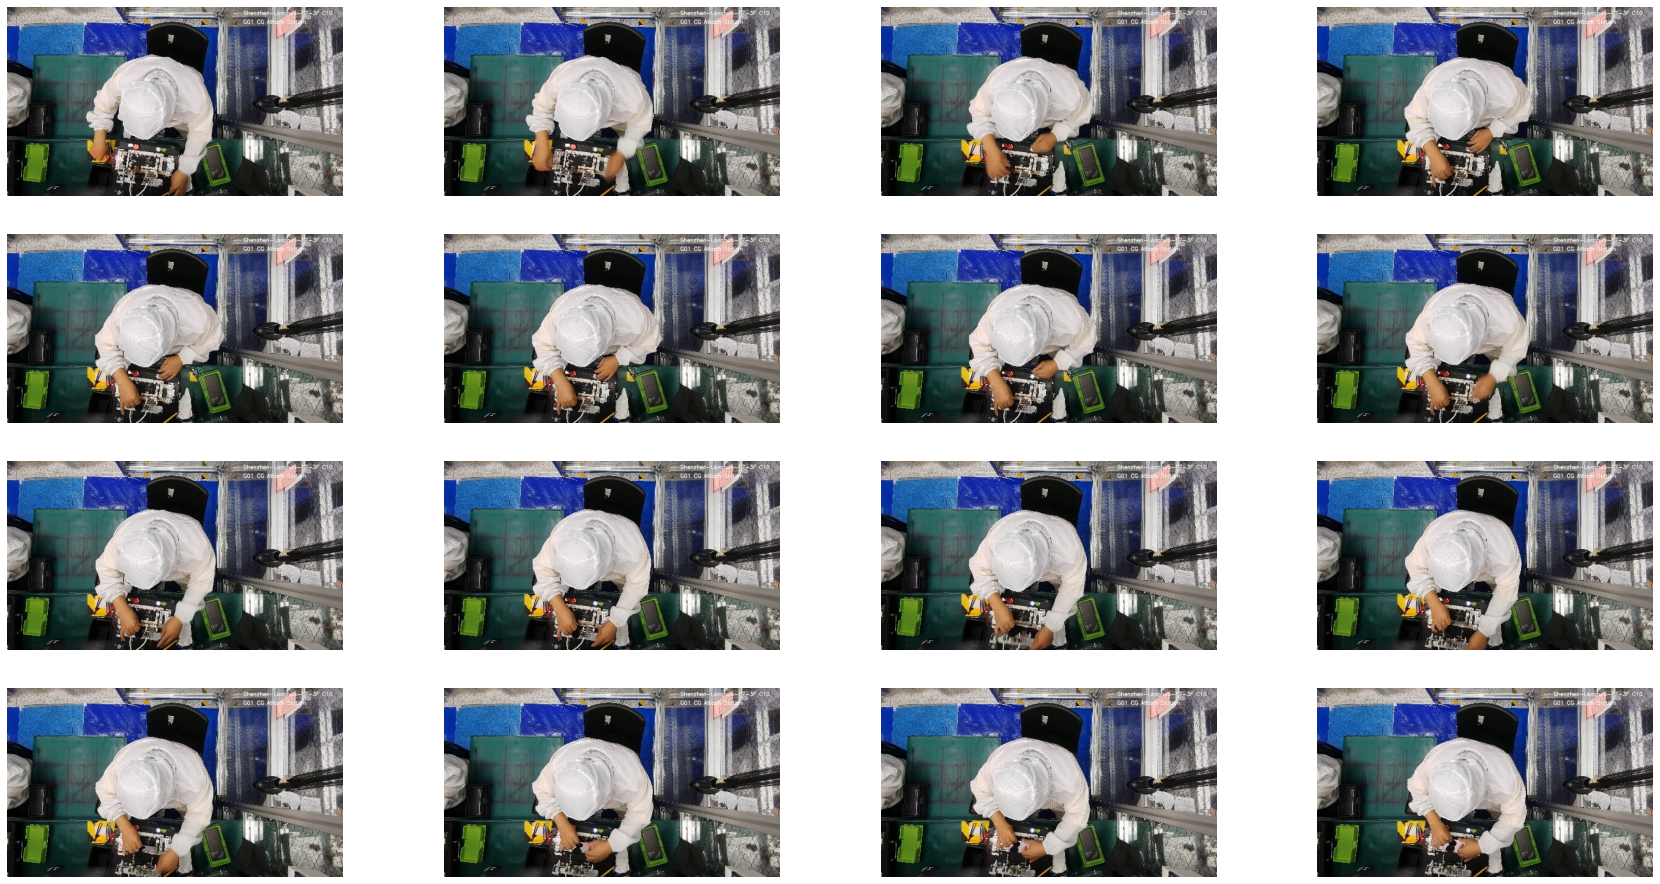

self.countL=[179, 183, 171, 487]


In [229]:
obj = LabeledCsv("../_data/20220810/imgs/", "../_data/20220810/downstream_20220810_20", txtPath="../_data/_labels/20220810_20.txt", classL=['open','tear','close'])
obj.cut()
obj.vis(1)
obj.getCounts()

In [234]:
os.path.abspath("../_data/20220810/imgs/")

'/home/jovyan/data-vol-1/VideoMAE/_data/20220810/imgs'